In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from scipy import integrate
from tqdm.notebook import tqdm
import pickle

import sys
sys.path.append('..')

import jax.numpy as jnp
from jax import jit, vmap

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc_file
rc_file('../matplotlibrc')

In [2]:
from utils.units_constants import *

## Gegenschein and Forwardschein with 3D galactic synchrotron model

Following [Radio observational constraints on Galactic 3D-emission models](https://arxiv.org/pdf/0711.1572.pdf)

In [3]:
## units
# length: kpc
# B field: muGauss

### Coordinates
Cylindrical $(R, \phi, z)$ where $\phi=0$ corresponds to $l=0$ \
$R_\text{sun}$ is assumed to be 8.5 kpc.

### 6.1. Thermal electron density
#### 6.1.1. The model for diffuse ionized gas – NE2001
<img src="plots/NE2001.png" alt="drawing" width="400"/>

#### 6.1.2. The filling factor of the DIG – from free-free emission at 22.8 GHz
Filling factor of diffuse ionized gas (DIG)
$$f_e\equiv\frac{\langle n_e\rangle^2}{\langle n_e^2\rangle}$$
Berkhuijsen et al. (2006) derives
$$f_e(z)=\begin{cases}0.07\exp(|z|/0.5\text{kpc})\quad\\
  0.32\quad\text{for }z>0.75\text{kpc}\end{cases} $$

#### 6.1.3. The filling factor of the DIG – from low-frequency absorption
#### 6.1.4. Remarks
In summary the NE2001 model combined with the filling factor obtained by Berkhuijsen et al. (2006) are proven to be sufficient to model the low latitude DIG. 

### 6.2. Regular magnetic field properties
Total magnetic field = regular component + random component
$$B_\text{tot}=B+b.$$
Regular component has a disk and a halo component
$$B=B^D+B^H.$$
The former is constrained by RMs near the Galactic plane ($|b|<5^\circ$) and the latter by an all-sky RM map from EGS data.

#### 6.2.1. The disk field
Axi-symmetric spiral (ASS) or  Bi-symmetric spiral (BSS)

We collected a number of published models and
checked them for their ability to simulate the observed RMs in
the Galactic plane. The results are shown in Fig. 9. Obviously
none of the models is able to reproduce the observed systematic
features. This motivates us to revise the parameters previously
used.

\begin{equation}
\begin{cases}
B^D_R = D_1(R,\phi,z)D_2(R,\phi,z)\sin p \\
B^D_\phi = -D_1(R,\phi,z)D_2(R,\phi,z)\cos p \\
B^D_z = 0
\end{cases}
\end{equation}
where $D_1(R, \phi, z)$ constrains the spatial variation of the field
strength and $D_2(R, \phi, z)$ introduces reversals or asymmetries. $p$ is the pitch angle defined in the following graph (found [here](https://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1994A%26A...288..759H&defaultprint=YES&filetype=.pdf)):\
<img src="plots/pitch_angle.png" alt="drawing" width="400"/>

We use
$$D_1(R,z)=\begin{cases}
B_0\exp\left(-\frac{R-R_\bigodot}{R_0}-\frac{|z|}{z_0}\right)\quad &\text{for }R>R_c \\
B_c &\text{for }R<R_c\\
\end{cases}$$

The regular $z$-component of the Galactic magnetic field is
very small. Its strength is about 0.2 µG to 0.3 µG as estimated
by Han & Qiao (1994). We assume $B^D_z$ to be zero in our models.

We list three different magnetic field models
1. the ASS model plus reversals in rings (ASS+RING) -> AR
1. the ASS model plus reversals following arms (ASS+ARM) -> AA
1. the BSS model -> BS

## Convention
cylindrical coordinates: s: radius, t: theta, z: height \
stz: [[s0, s1, ...], [t0, t1, ...], [z0, z1, ...]] \
vector: [[vs0, vs1, ...], [vt0, vt1, ...], [vz0, vz1, ...]]

In [3]:
from utils.common import norm

In [4]:
def BD_AR(stz_s): # [muG] ( [[kpc], [1], [kpc]] ), vectorized
    R_s, t_s, z_s = stz_s
    R0, z0, Rc, Rsun = 10, 1, 5, 8.5 # kpc
    B0, Bc = 2, 2 # muG
    
    D1_s = jnp.where(R_s < Rc, Bc, B0 * jnp.exp( -(R_s-Rsun)/R0 -jnp.abs(z_s)/z0 ))
    D2_s = jnp.array(jnp.logical_or((7.5 < R_s), jnp.logical_and(5 < R_s, R_s < 6)), dtype=float) * 2 - 1
    BDt_s = -D1_s*D2_s
    return jnp.array([jnp.zeros_like(BDt_s), BDt_s, jnp.zeros_like(BDt_s)])

def BD_BS(stz_s): # [muG] ( [[kpc], [1], [kpc]] ), vectorized
    R_s, t_s, z_s = stz_s
    R0, z0, Rc, Rsun = 6, 1, 3, 8.5 # kpc
    B0, Bc = 2, 2 # muG
    
    D1_s = jnp.where(R_s < Rc, Bc, B0 * jnp.exp( -(R_s-Rsun)/R0 -jnp.abs(z_s)/z0 ))
    Rb_s = jnp.where(R_s > 6,  9,  6)
    p_s  = jnp.where(R_s > 6, -10/180*jnp.pi, -15/180*jnp.pi)
    beta_s = 1/jnp.tan(p_s)
    D2_s = -jnp.cos(t_s + beta_s*jnp.log(R_s/Rb_s))
    D1D2_s = D1_s*D2_s
    return jnp.array([D1D2_s*jnp.sin(p_s), -D1D2_s*jnp.cos(p_s), jnp.zeros_like(D1D2_s)])

In [5]:
def visualize_hv(func, smax, h_zval, zmax, v_tval, npix, title=''):
    
    x_s = jnp.linspace(-smax, smax, npix)
    y_s = jnp.linspace(-smax, smax, npix)
    x_ss, y_ss = jnp.meshgrid(x_s, y_s)
    
    x_in = jnp.reshape(x_ss, (npix**2,))
    y_in = jnp.reshape(y_ss, (npix**2,))
    stz_in = jnp.array([jnp.sqrt(x_in**2+y_in**2),
                        jnp.arctan2(y_in, x_in),
                        jnp.full_like(x_in, h_zval)])
    hslice = jnp.reshape(func(stz_in), (npix,npix))
    
    s_s = jnp.linspace(0, smax, npix)
    z_s = jnp.linspace(-zmax, zmax, npix)
    s_ss, z_ss = jnp.meshgrid(s_s, z_s)
    
    s_in = jnp.reshape(s_ss, (npix**2,))
    z_in = jnp.reshape(z_ss, (npix**2,))
    stz_in = jnp.array([s_in,
                        jnp.full_like(s_in, v_tval),
                        z_in])
    vslice = jnp.reshape(func(stz_in), (npix,npix))

    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    vmax = jnp.max(jnp.array([jnp.max(hslice[hslice<jnp.inf]), jnp.max(vslice[vslice<jnp.inf])]))
    im = axs[0].imshow(hslice, extent=(-smax, smax, -smax, smax), vmin=0, vmax=vmax, cmap='magma')
    axs[1].imshow(vslice, extent=(0, smax, -zmax, zmax), vmin=0, vmax=vmax, cmap='magma')
    axs[0].set(xlabel='x [kpc]', ylabel='y [kpc]', title=title+f'$z={h_zval}$~kpc')
    axs[1].set(xlabel='x [kpc]', ylabel='z [kpc]', title=title+f'$\phi={v_tval}^\circ$')
    fig.colorbar(im, ax=axs, orientation='horizontal', aspect=40)
    plt.show()

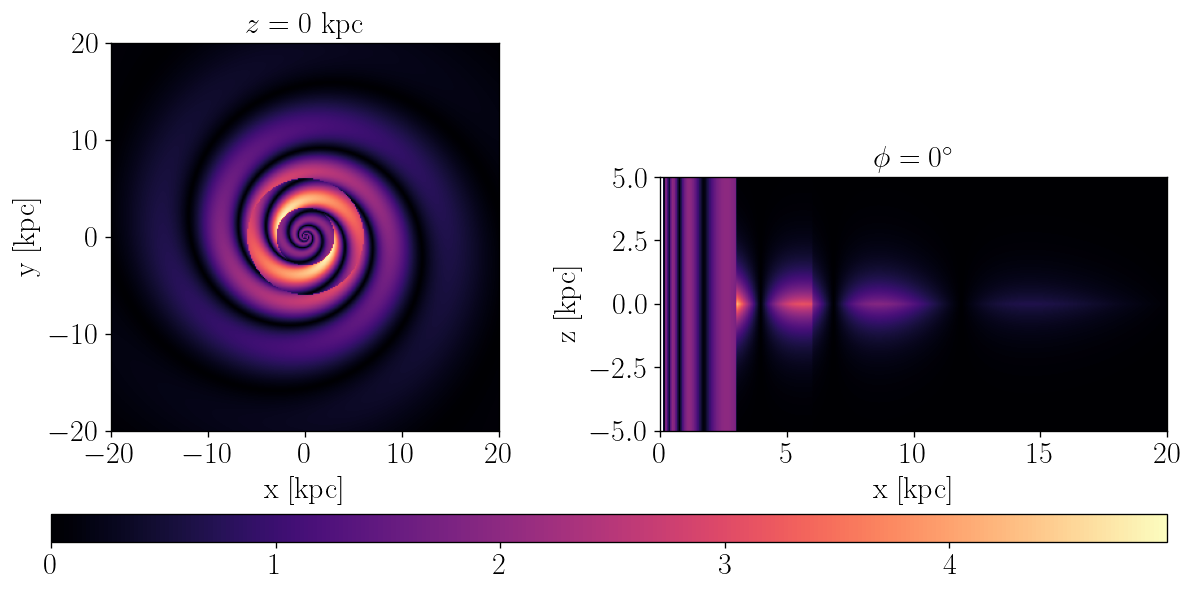

In [7]:
visualize_hv(lambda x: norm(BD_BS(x)), 20, 0, 5, 0, 300)

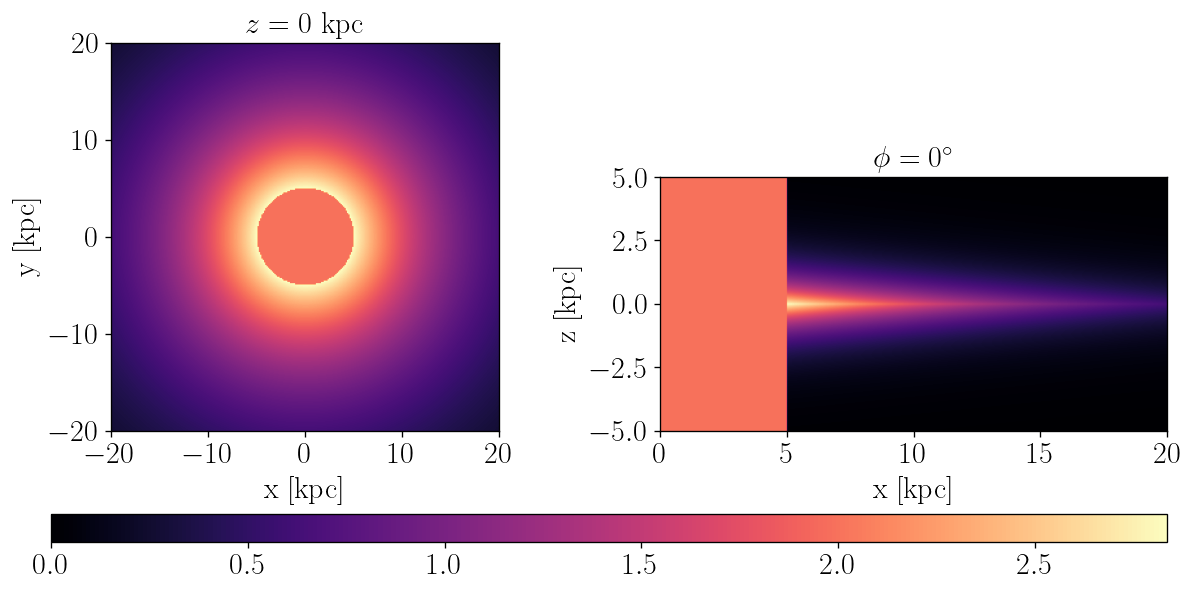

In [8]:
visualize_hv(lambda x: norm(BD_AR(x)), 20, 0, 5, 0, 300)

#### 6.2.2 Halo regular field
<img src="plots/Halo_B_field.png" alt="drawing" width="400"/>

In [6]:
def BH(stz_s): # [muG] ( [[kpc], [1], [kpc]] ), vectorized
    R_s, t_s, z_s = stz_s
    BH0, RH0, zH0 = 10, 4, 1.5
    zH1_s = jnp.where(jnp.abs(z_s) < zH0, 0.2, 0.4)
    return jnp.array([jnp.zeros_like(zH1_s),
                      BH0 / (1+((jnp.abs(z_s)-zH0)/zH1_s)**2)*R_s/RH0*jnp.exp(-(R_s-RH0)/RH0),
                      jnp.zeros_like(zH1_s)])

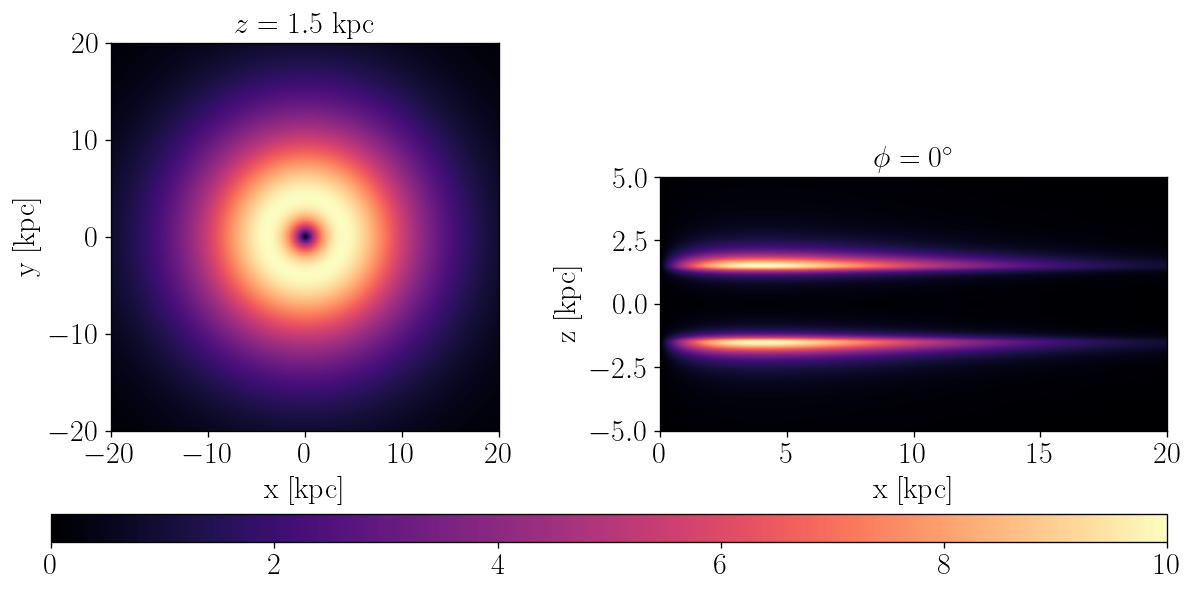

In [10]:
visualize_hv(lambda x: norm(BH(x)), 20, 1.5, 5, 0, 300)

#### 6.3.2. CR electron density
<img src="plots/CRelec_text.png" alt="drawing" width="400"/>

In [7]:
spec_ind_p = 3
spec_ind_alpha = (spec_ind_p+1)/2

def n(stz): # [unnorm] ( [[kpc], [1], [kpc]] ), vectorized
    s, t, z = stz
    Rsun = 8.5
    return jnp.where(jnp.abs(z)>1, 0, jnp.exp(-(jnp.maximum(s, 3) - Rsun)/8 -jnp.abs(z)))

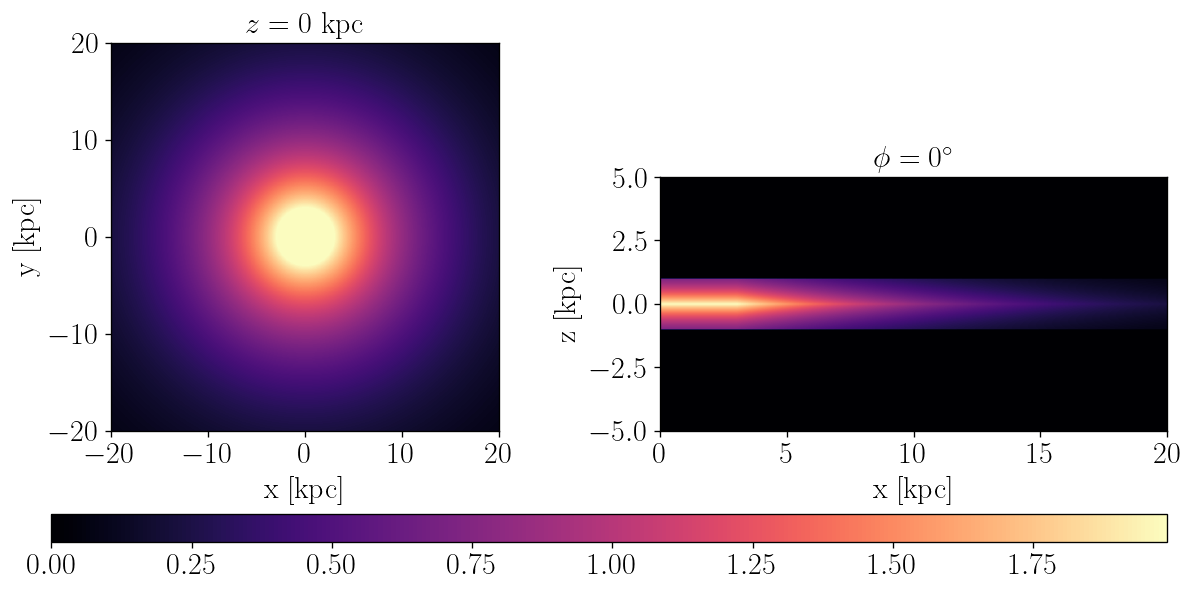

In [12]:
visualize_hv(n, 20, 0, 5, 0, 300)

## 0. Config

In [51]:
B_scheme = 'AR_H'
#B_scheme = 'BS_H'

## 1. Synchrotron intensity at Sun location

In [52]:
from utils.common import GCstz, Glbd, intg_ds, unit_vec, los_direction, GCxyz_stz, vstz2vxyz_stz, cross_product

power density $p(\vec x)=n(\vec x)B(\vec x)^\alpha$

In [53]:
# using total magnetic field (not caring about the angle)
def power_density_no_LOS(stz): # vectorized
    B = norm(BH(stz) + BD_AR(stz))
    return n(stz) * B**spec_ind_alpha

def power_density(stz): # vectorized
    if B_scheme == 'AR_H':
        Bvstz = BH(stz) + BD_AR(stz)
    elif B_scheme == 'BS_H':
        Bvstz = BH(stz) + BD_BS(stz)
    else:
        raise ValueError(f'Invalid B_scheme {B_scheme}')
    Bvxyz = vstz2vxyz_stz(Bvstz, stz)
    los_vxyz = los_direction(GCxyz_stz(stz))
    B = norm(cross_product(Bvxyz, los_vxyz))
    return n(stz) * B**spec_ind_alpha

In [54]:
@jit
@vmap
def I_src(lb):
    l, b = lb
    lbd = jnp.vstack([ jnp.full_like(intg_ds, l),
                       jnp.full_like(intg_ds, b),
                       intg_ds ])
    I_integrands = power_density(GCstz(lbd))
    return jnp.trapz(I_integrands, intg_ds)

## View $I_{src}$

In [55]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
print(f'Angular resolution ~ {hp.nside2resol(NSIDE, arcmin=True):.2f} arcmin')
print(f'Number of pixels: {NPIX}')

co_b_s, l_s = hp.pix2ang(NSIDE, range(NPIX))
b_s = jnp.pi/2 - co_b_s
lb_s = jnp.stack([l_s, b_s], axis=-1)

# antipodal indices
anti_co_b_s = jnp.pi - co_b_s
anti_l_s   = l_s + jnp.pi
anti_inds = hp.ang2pix(NSIDE, anti_co_b_s, anti_l_s)

Angular resolution ~ 109.94 arcmin
Number of pixels: 12288


In [57]:
# cartesian
l_s_cart = jnp.linspace(-jnp.pi, jnp.pi, 180)
b_s_cart = jnp.linspace(jnp.pi/2, -jnp.pi/2, 90)
cart_shape = (len(b_s_cart), len(l_s_cart))

anti_l_s_cart = l_s_cart + np.pi
anti_b_s_cart = - b_s_cart

In [58]:
I_src_map = I_src(lb_s)

In [59]:
I_src_cart_map = np.zeros(cart_shape)

for ib, b in enumerate(tqdm(b_s_cart)):
    lb_s_row = jnp.stack([l_s_cart, jnp.full_like(l_s_cart, b)], axis=-1)
    I_src_cart_map[ib] = I_src(lb_s_row)

  0%|          | 0/90 [00:00<?, ?it/s]

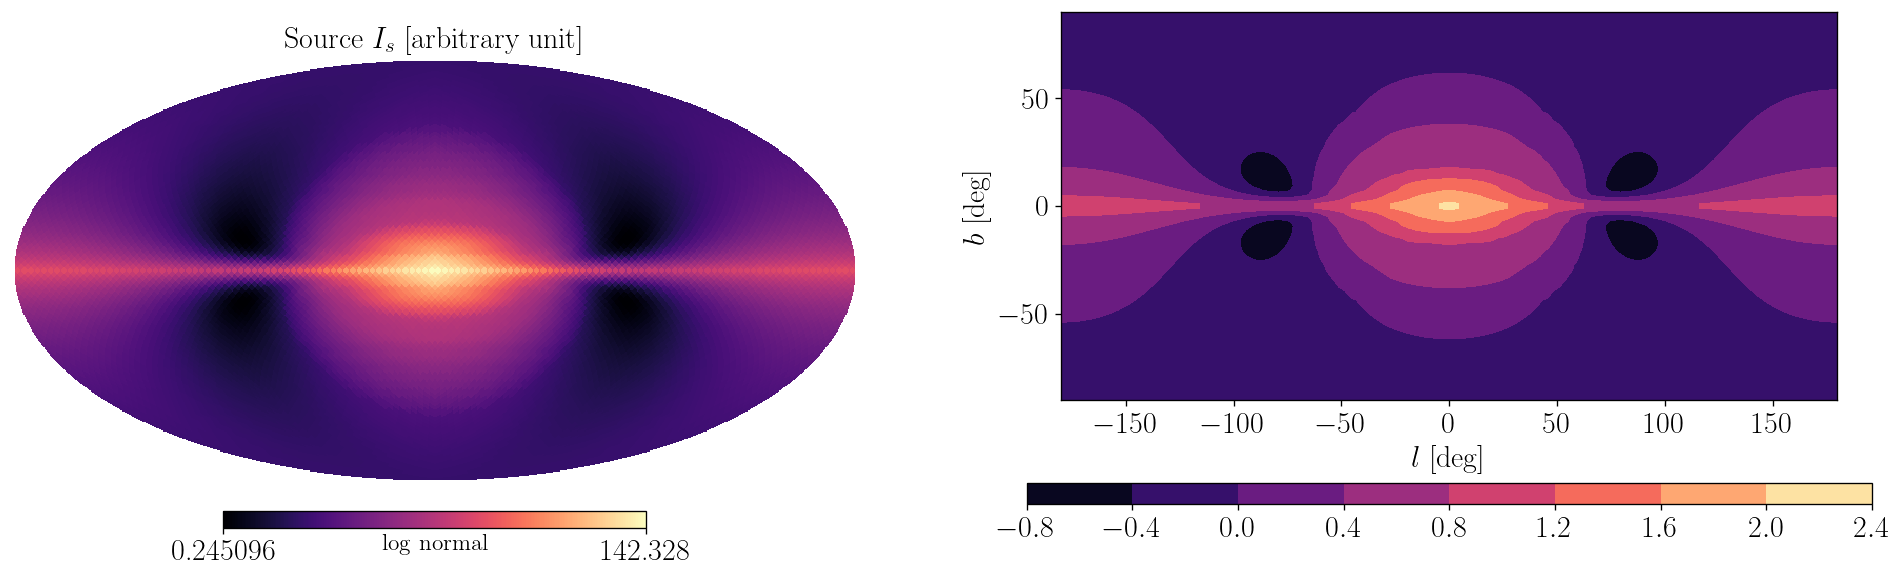

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

plt.axes(axs[0])
hp.mollview(I_src_map, norm='log', cmap='magma',
            title=r'Source $I_s$ [arbitrary unit]', unit='log normal', hold=True)
im = axs[1].contourf(jnp.rad2deg(l_s_cart), jnp.rad2deg(b_s_cart), np.log10(I_src_cart_map),
               cmap='magma')
axs[1].set(xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(aspect=1)
fig.colorbar(im, ax=axs[1], orientation='horizontal', aspect=40)

## 2. Reference intensities

### 2.1 Naive gegenschein intensity

In [61]:
from utils.common import rho_integral

In [62]:
rho_integral_map = rho_integral(lb_s)

In [63]:
# antipodal Haslam map
Ig_map = I_src_map[anti_inds] * rho_integral_map

In [64]:
Ig_cart_map = np.zeros(cart_shape)

for ib, b in enumerate(tqdm(b_s_cart)):
    lb_s_row = jnp.stack([l_s_cart, jnp.full_like(l_s_cart, b)], axis=-1)
    anti_lb_s_row = jnp.stack([anti_l_s_cart, jnp.full_like(anti_l_s_cart, -b)], axis=-1)
    Ig_cart_map[ib] = I_src(anti_lb_s_row) * rho_integral(lb_s_row)

  0%|          | 0/90 [00:00<?, ?it/s]

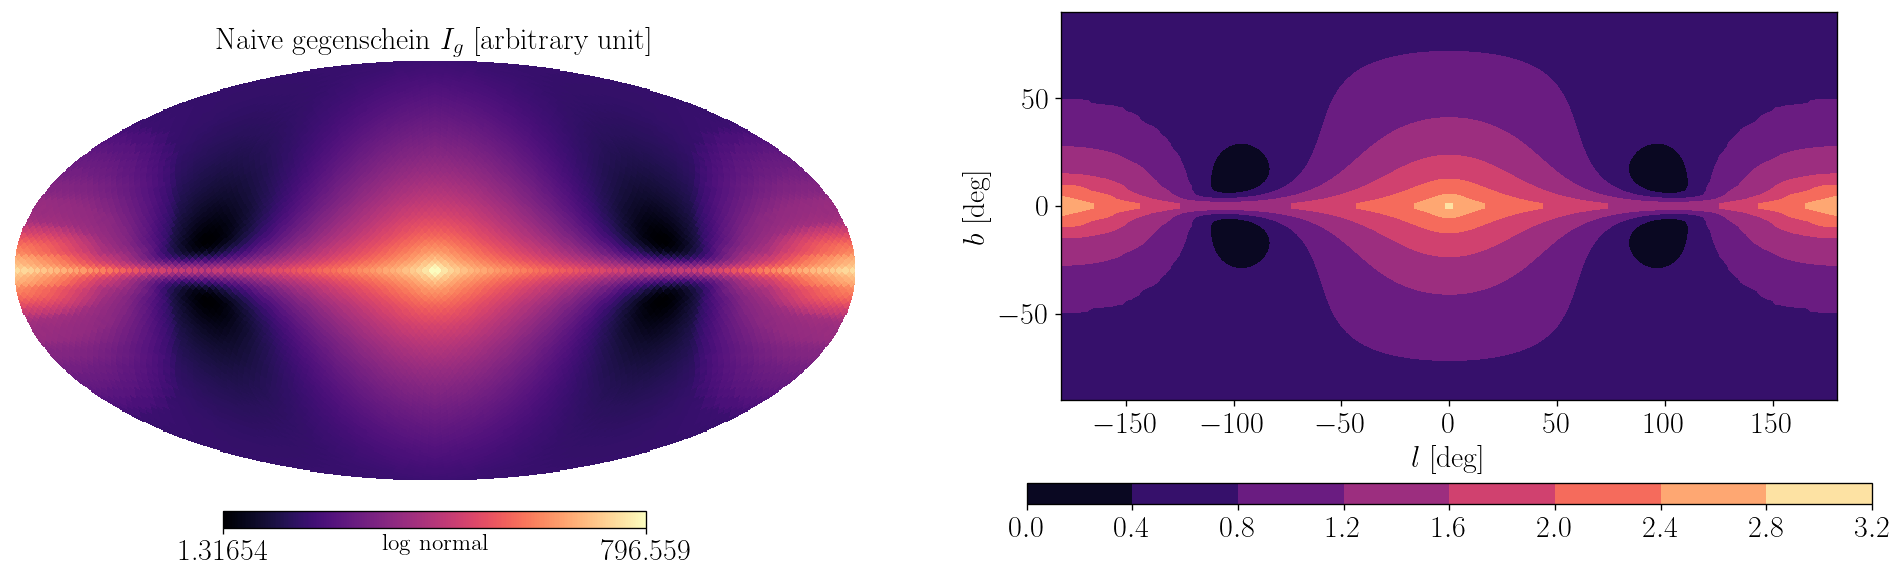

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(20,6))

plt.axes(axs[0])
hp.mollview(Ig_map, norm='log', cmap='magma',
            title=r'Naive gegenschein $I_g$ [arbitrary unit]', unit='log normal', hold=True)
im = axs[1].contourf(jnp.rad2deg(l_s_cart), jnp.rad2deg(b_s_cart), np.log10(Ig_cart_map),
               cmap='magma')
axs[1].set(xlabel=r'$l$ [deg]', ylabel=r'$b$ [deg]')
axs[1].set(aspect=1)
fig.colorbar(im, ax=axs[1], orientation='horizontal', aspect=40)

### 2.2 Forwardschein reference intensity

In [66]:
from utils.common import rho_NFW

In [67]:
rho_integral_ref = rho_NFW(r_Sun) * 10 # [GeV/cm^3] * [kpc]
If_map = I_src_map * rho_integral_ref # looks the same as souce I_s
If_cart_map = I_src_cart_map * rho_integral_ref

## 3. Other scheins

In [28]:
from utils.common import Gr

### 3.1 Gegenschein (focused)

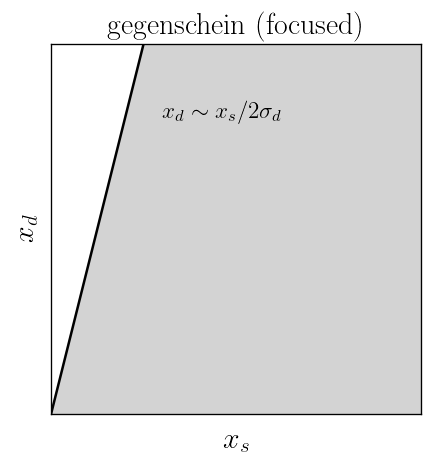

In [29]:
# gegenschein focused: allowed region
fig, ax = plt.subplots()
ax.plot([0,1],[0,4], 'k')
ax.fill_between([0,1],[0,4],[0,0], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='gegenschein (focused)')
ax.set(xticks=[], yticks=[])
ax.text(0.3, 0.8, r'$x_d\sim x_s/2\sigma_d$')
fig.savefig('gegenschein_region.pdf')

In [30]:
# gegenschein focused
SIN_2SIGMAD = jnp.sin(2 * sigmad_over_c)
def x_d_gmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 - 2*sigmad_over_c) / SIN_2SIGMAD)

In [31]:
def drho_integral_from_zero(l, b, xdmax):
    xds = jnp.logspace(jnp.log10(0.1), jnp.log10(xdmax), 300)
    lbd = jnp.vstack([ jnp.full_like(xds, l),
                       jnp.full_like(xds, b),
                       xds ])
    return jnp.trapz(rho_NFW(Gr(lbd)), xds)
drho_integral_from_zero = jit(vmap(drho_integral_from_zero, in_axes=(None, None, 0)))

def Ig_focused(lb, theta_i0):
    l, b = lb
    xss = intg_ds[1:]
    lbd = jnp.vstack([ jnp.full_like(xss, jnp.pi+l), # x_s in antipodal direction
                       jnp.full_like(xss, -b),
                       xss ])
    xdmaxs = x_d_gmax(jnp.abs(xss), theta_i0)
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral_from_zero(l, b, xdmaxs), xss)
Ig_focused = jit(Ig_focused)
#Ig_focused = jit(vmap(Ig_focused, in_axes=(0, None)))

In [32]:
Ig_focused_map = []
for lb in tqdm(lb_s):
    Ig_focused_map.append(Ig_focused(lb, jnp.pi/3))
Ig_focused_map = np.array(Ig_focused_map)

  0%|          | 0/12288 [00:00<?, ?it/s]

In [33]:
# cartesian
Ig_focused_cart_map = np.zeros(cart_shape)

for il, l in enumerate(tqdm(l_s_cart)):
    for ib, b in enumerate(b_s_cart):
        Ig_focused_cart_map[ib][il] = Ig_focused((l, b), jnp.pi/3)

  0%|          | 0/180 [00:00<?, ?it/s]

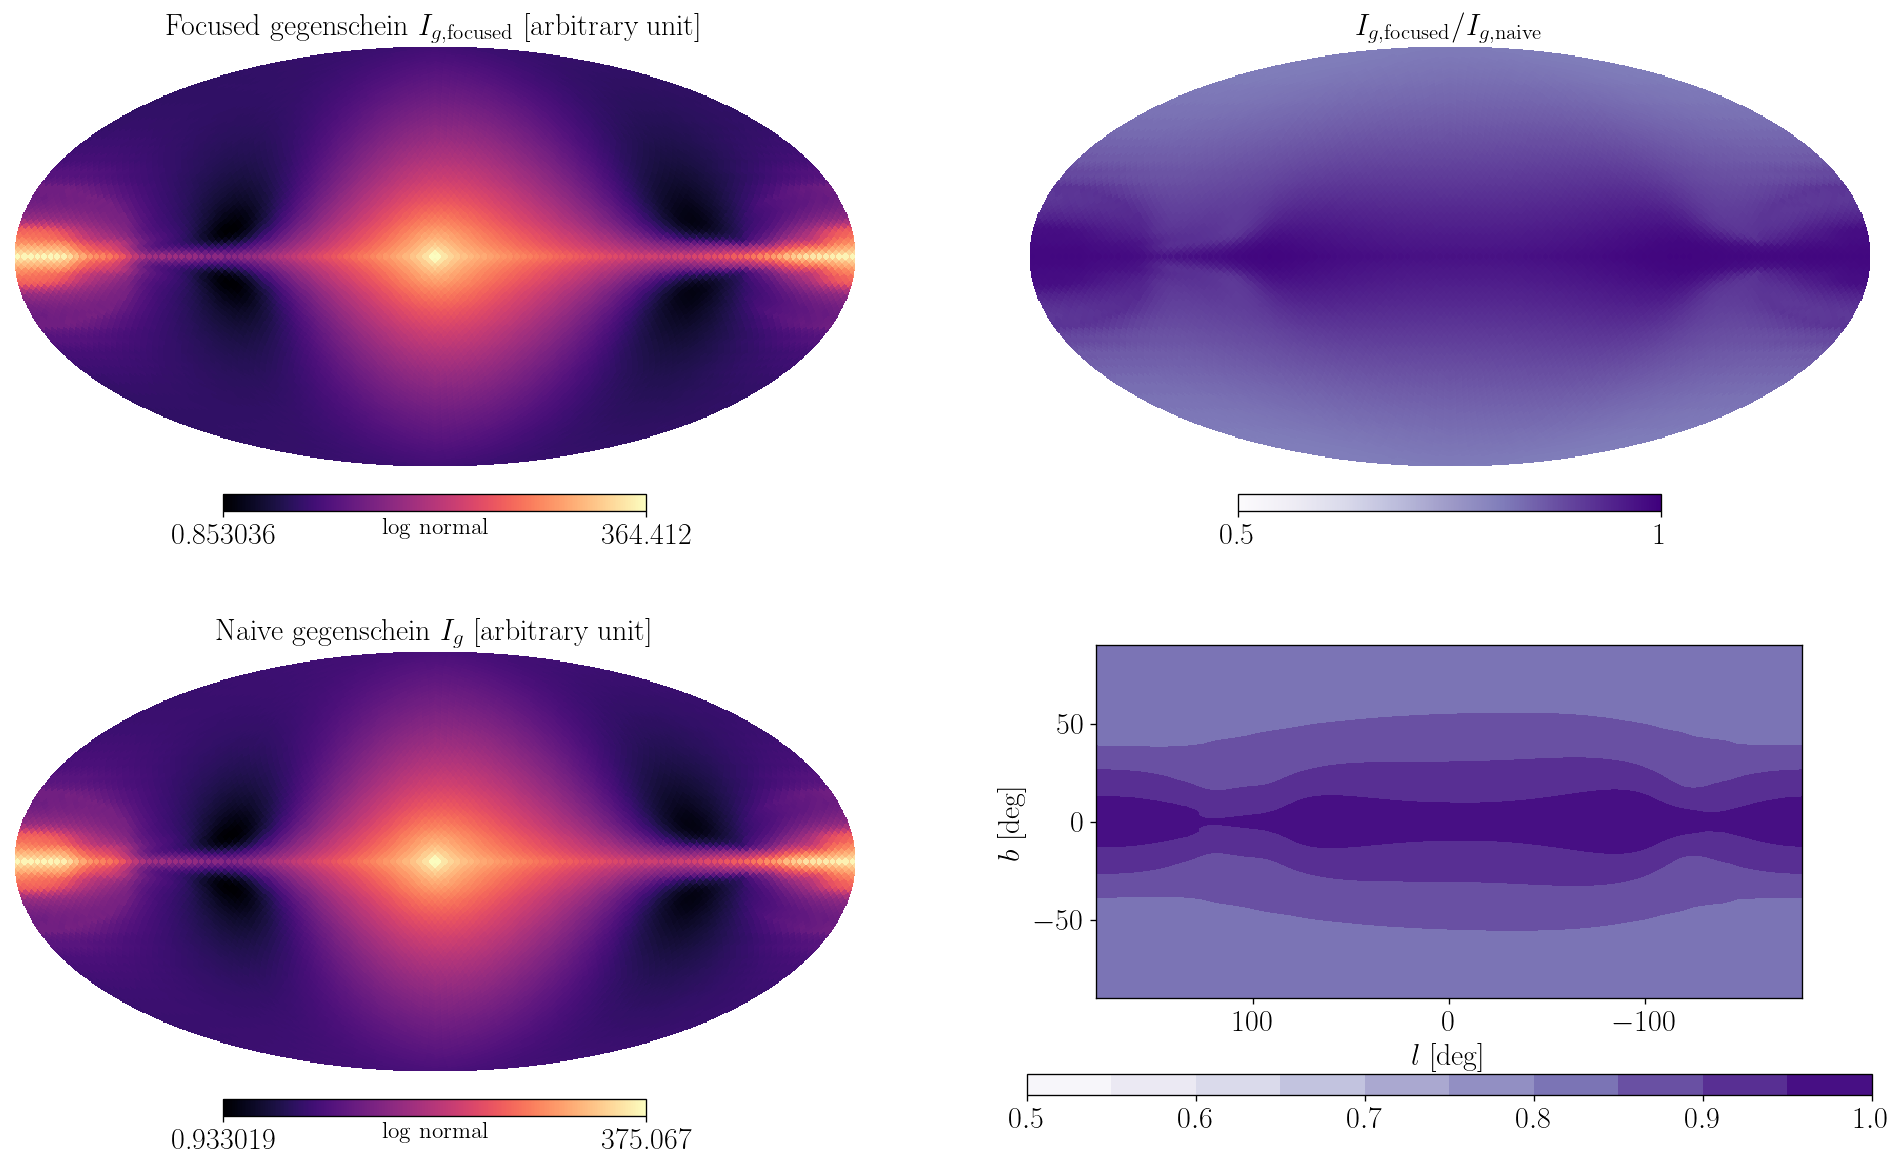

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(20,12))
#plt.figure()

config_I = dict(norm='log', cmap='magma', unit='log normal', hold=True)
config_r = dict(cmap='Purples', hold=True, min=0.5, max=1)

plt.axes(axs[0][0])
hp.mollview(Ig_focused_map, title=r'Focused gegenschein $I_{g,\mathrm{focused}}$ [arbitrary unit]', **config_I)
plt.axes(axs[1][0])
hp.mollview(Ig_map, title=r'Naive gegenschein $I_{g}$ [arbitrary unit]', **config_I)
plt.axes(axs[0][1])
hp.mollview(Ig_focused_map/Ig_map, title=r'$I_{g,\mathrm{focused}}/I_{g,\mathrm{naive}}$', **config_r)

im = axs[1][1].contourf(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart), Ig_focused_cart_map/Ig_cart_map,
                        levels=np.linspace(0.5, 1, 10+1), cmap='Purples')
axs[1][1].set(aspect='equal')
axs[1][1].invert_xaxis()
axs[1][1].set(xlabel='$l$ [deg]', ylabel='$b$ [deg]')
fig.colorbar(im, ax=axs[1][1], orientation='horizontal', aspect=40);

### 3.2 Front gegenschein

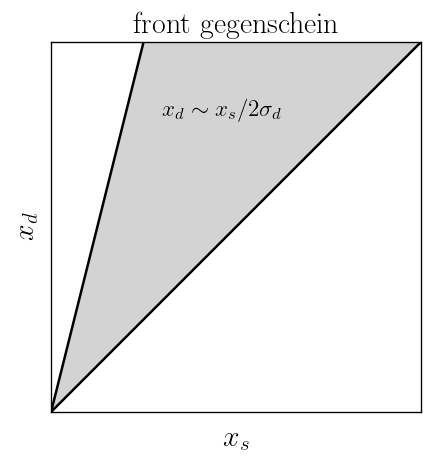

In [57]:
# front gegenschein: allow region
fig, ax = plt.subplots()
ax.plot([0,1],[0,4], 'k')
ax.plot([0,1],[0,1], 'k')
ax.fill_between([0,1],[0,4],[0,1], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='front gegenschein')
ax.set(xticks=[], yticks=[])
ax.text(0.3, 0.8, r'$x_d\sim x_s/2\sigma_d$')
fig.savefig('front_gegenschein_region.pdf')

In [58]:
# front gegenschein
def x_d_fgmax(x_s, theta_i0):
    return jnp.abs(x_s * jnp.sin(theta_i0 + 2*sigmad_over_c) / SIN_2SIGMAD)

In [59]:
def drho_integral(l, b, xdmin, xdmax):
    xds = jnp.logspace(jnp.log10(xdmin), jnp.log10(xdmax), 300)
    lbd = jnp.vstack([ jnp.full_like(xds, l),
                       jnp.full_like(xds, b),
                       xds ])
    return jnp.trapz(rho_NFW(Gr(lbd)), xds)
drho_integral = jit(vmap(drho_integral, in_axes=(None, None, 0, 0)))

def Ig_front(lb, theta_i0):
    l, b = lb
    xss = intg_ds[1:]
    lbd = jnp.vstack([ jnp.full_like(xss, l), # x_s in original direction
                       jnp.full_like(xss, b),
                       xss ])
    xdmaxs = x_d_fgmax(xss, theta_i0)
    xdmins = xss
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral(l, b, xdmins, xdmaxs), xss)
Ig_front = jit(Ig_front)

In [60]:
Ig_front_map = []
for lb in tqdm(lb_s):
    Ig_front_map.append(Ig_front(lb, jnp.pi/3))
Ig_front_map = np.array(Ig_front_map)

  0%|          | 0/12288 [00:00<?, ?it/s]

In [61]:
# cartesian
Ig_front_cart_map = np.zeros(cart_shape)

for il, l in enumerate(tqdm(l_s_cart)):
    for ib, b in enumerate(b_s_cart):
        Ig_front_cart_map[ib][il] = Ig_front((l, b), jnp.pi/3)

  0%|          | 0/180 [00:00<?, ?it/s]

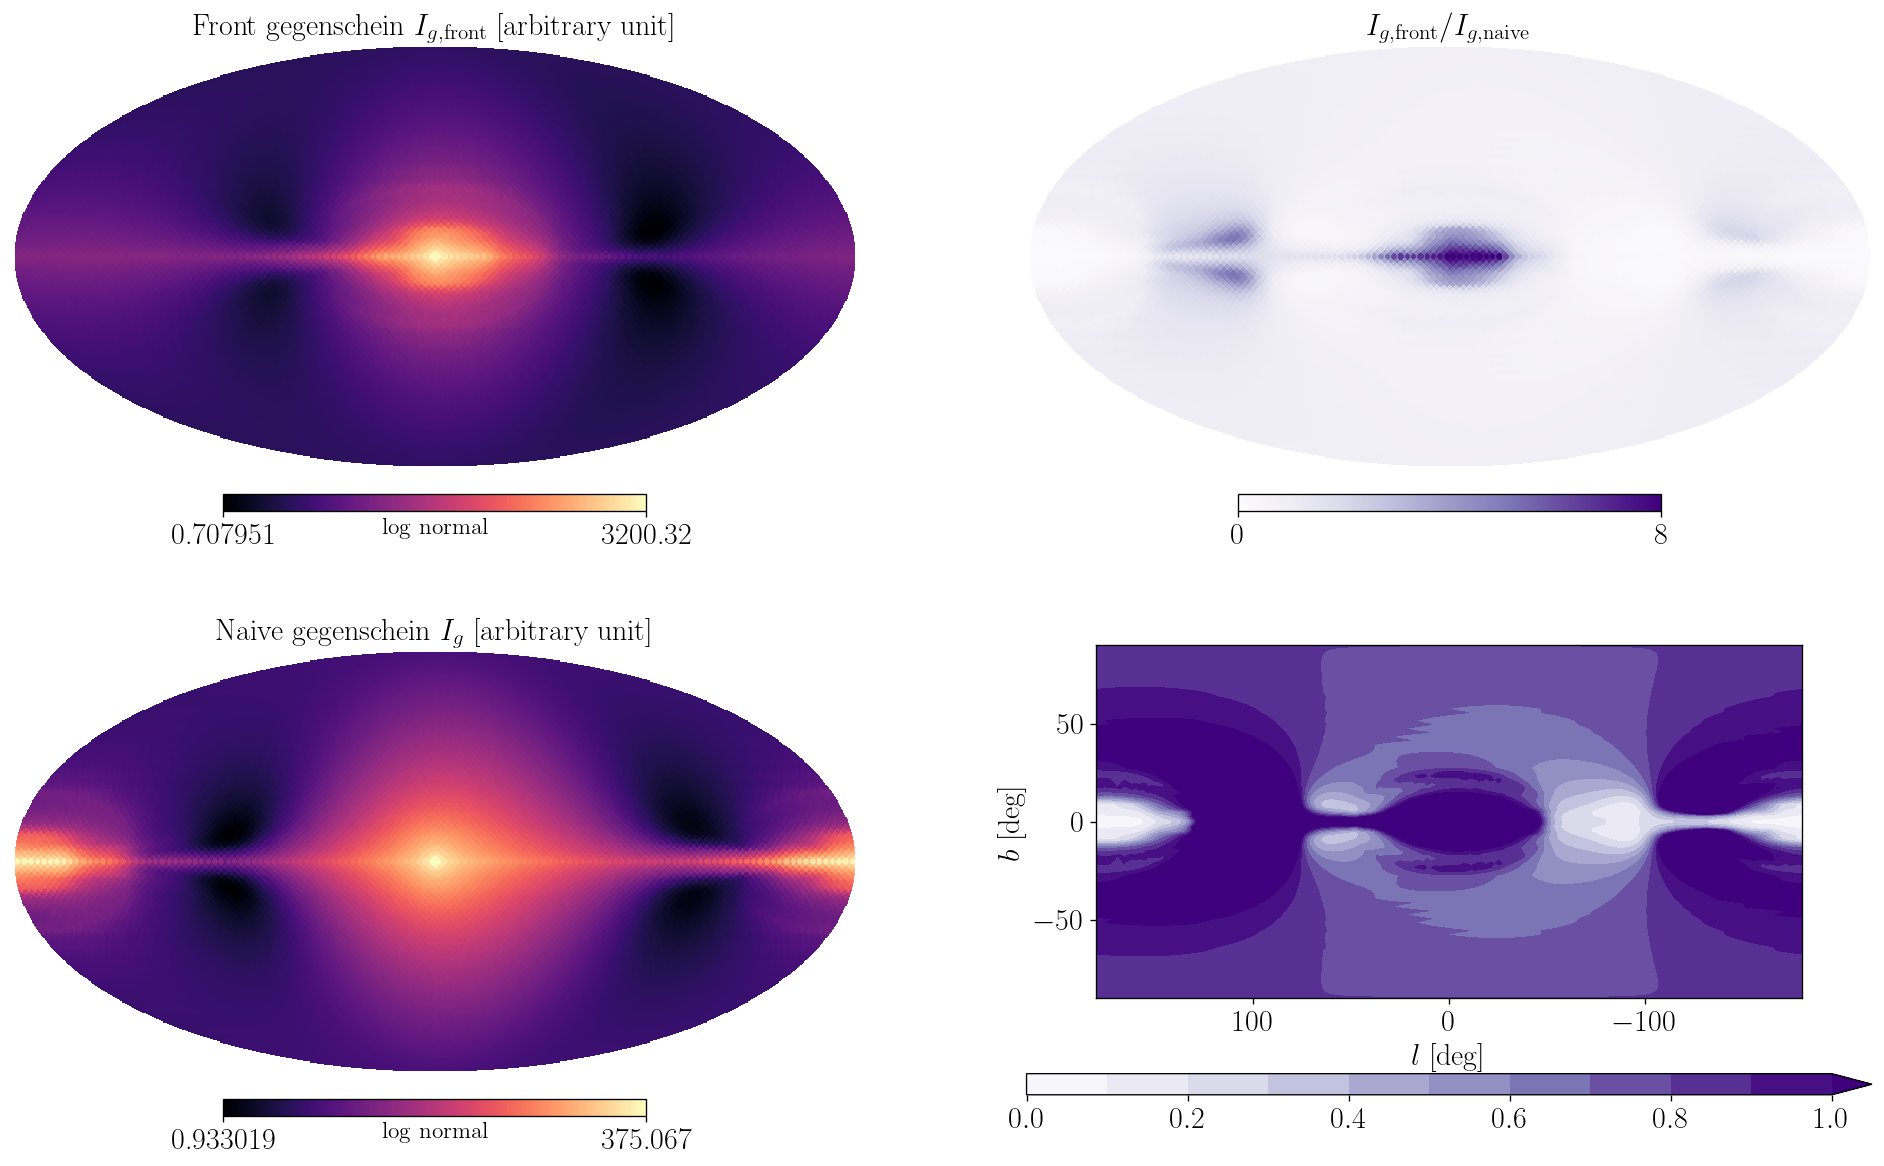

In [62]:
I_map = Ig_front_map
I_cart_map = Ig_front_cart_map

fig, axs = plt.subplots(2, 2, figsize=(20,12))
#plt.figure()

config_I = dict(norm='log', cmap='magma', unit='log normal', hold=True)
config_r = dict(cmap='Purples', hold=True, min=0, max=8)

plt.axes(axs[0][0])
hp.mollview(I_map, title=r'Front gegenschein $I_{g,\mathrm{front}}$ [arbitrary unit]', **config_I)
plt.axes(axs[1][0])
hp.mollview(Ig_map, title=r'Naive gegenschein $I_{g}$ [arbitrary unit]', **config_I)
plt.axes(axs[0][1])
hp.mollview(I_map/Ig_map, title=r'$I_{g,\mathrm{front}}/I_{g,\mathrm{naive}}$', **config_r)

im = axs[1][1].contourf(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart), I_cart_map/Ig_cart_map,
                        levels=np.linspace(0, 1, 10+1), cmap='Purples', extend='max')
axs[1][1].set(aspect='equal')
axs[1][1].invert_xaxis()
axs[1][1].set(xlabel='$l$ [deg]', ylabel='$b$ [deg]')
fig.colorbar(im, ax=axs[1][1], orientation='horizontal', aspect=40);

### 3.3 Forwardschein

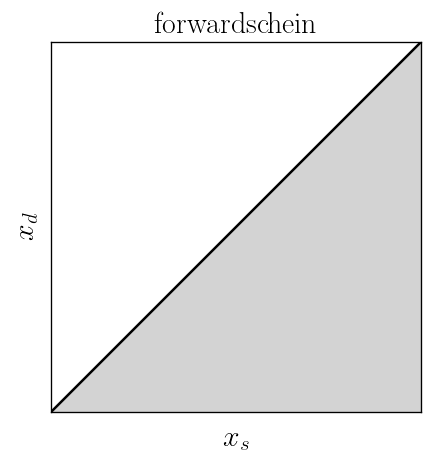

In [63]:
# forwardschein: allow region
fig, ax = plt.subplots()
ax.plot([0,1],[0,1], 'k')
ax.fill_between([0,1],[0,0],[0,1], color='lightgray')
ax.set(xlim=(0,1), ylim=(0,1), aspect=1)
ax.set(xlabel=r'$x_s$', ylabel=r'$x_d$', title='forwardschein')
ax.set(xticks=[], yticks=[]);
fig.savefig('forwardschein_region.pdf')

In [64]:
def I_forward(lb, theta_i0):
    l, b = lb
    xss = intg_ds[1:]
    lbd = jnp.vstack([ jnp.full_like(xss, l), # x_s in original direction
                       jnp.full_like(xss, b),
                       xss ])
    xdmaxs = xss
    return jnp.trapz(power_density(GCstz(lbd)) * drho_integral_from_zero(l, b, xdmaxs), xss)
I_forward = jit(I_forward)

In [65]:
I_forward_map = []
for lb in tqdm(lb_s):
    I_forward_map.append(I_forward(lb, jnp.pi/3))
I_forward_map = np.array(I_forward_map)

  0%|          | 0/12288 [00:00<?, ?it/s]

In [66]:
# cartesian
I_forward_cart_map = np.zeros(cart_shape)

for il, l in enumerate(tqdm(l_s_cart)):
    for ib, b in enumerate(b_s_cart):
        I_forward_cart_map[ib][il] = I_forward((l, b), jnp.pi/3)

  0%|          | 0/180 [00:00<?, ?it/s]

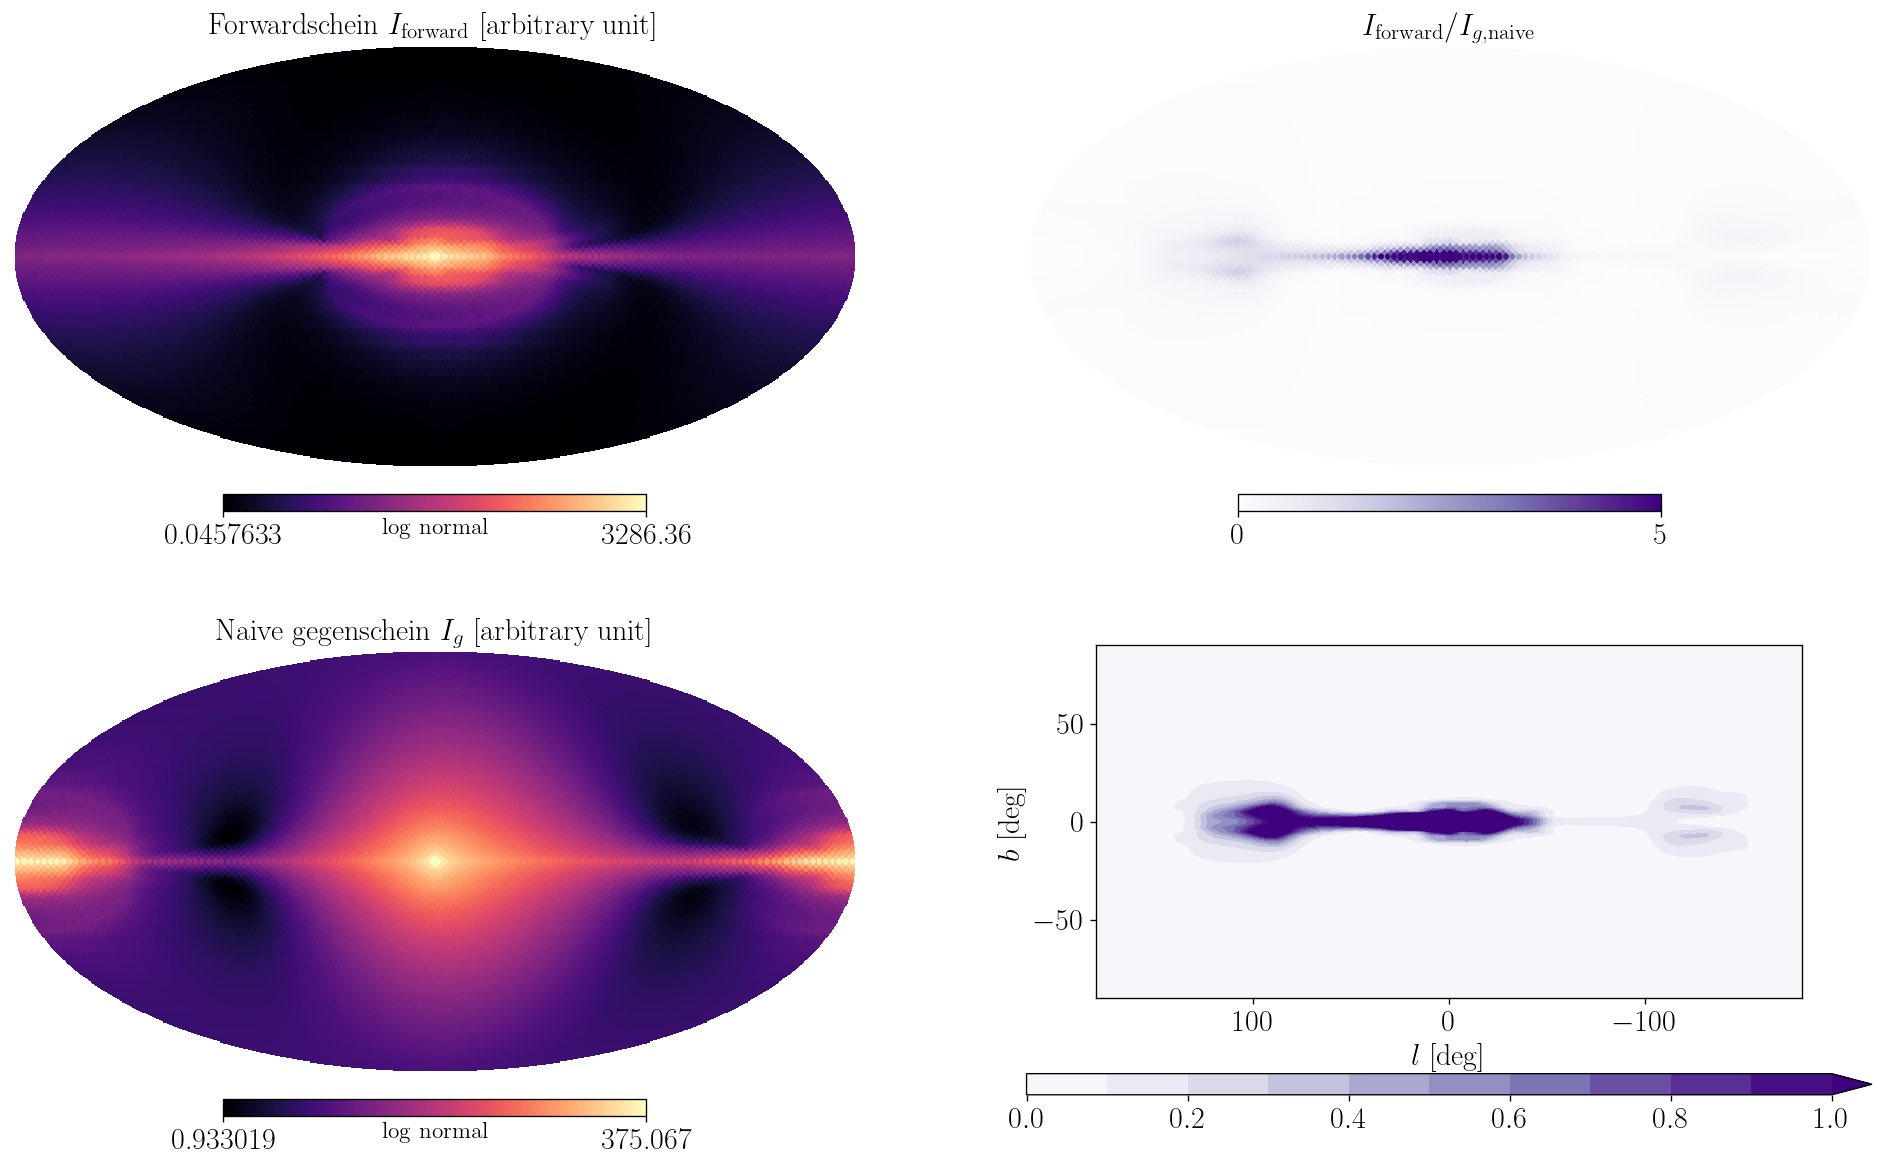

In [67]:
I_map = I_forward_map
I_cart_map = I_forward_cart_map

fig, axs = plt.subplots(2, 2, figsize=(20,12))
#plt.figure()

config_I = dict(norm='log', cmap='magma', unit='log normal', hold=True)
config_r = dict(cmap='Purples', hold=True, min=0, max=5)

plt.axes(axs[0][0])
hp.mollview(I_map, title=r'Forwardschein $I_{\mathrm{forward}}$ [arbitrary unit]', **config_I)
plt.axes(axs[1][0])
hp.mollview(Ig_map, title=r'Naive gegenschein $I_{g}$ [arbitrary unit]', **config_I)
plt.axes(axs[0][1])
hp.mollview(I_map/Ig_map, title=r'$I_{\mathrm{forward}}/I_{g,\mathrm{naive}}$', **config_r)

im = axs[1][1].contourf(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart), I_cart_map/Ig_cart_map,
                        levels=np.linspace(0, 1, 10+1), cmap='Purples', extend='max')
axs[1][1].set(aspect='equal')
axs[1][1].invert_xaxis()
axs[1][1].set(xlabel='$l$ [deg]', ylabel='$b$ [deg]')
fig.colorbar(im, ax=axs[1][1], orientation='horizontal', aspect=40);

In [ ]:
# save data
save_dict = {
    'naive': Ig_map,
    'naive_cart': Ig_cart_map,
    'focused': Ig_focused_map,
    'focused_cart': Ig_focused_cart_map,
    'front': Ig_front_map,
    'front_cart': Ig_front_cart_map,
    'forward': I_forward_map,
    'forward_cart': I_forward_cart_map,
    'forward_ref': If_map,
    'forward_ref_cart': If_cart_map
}

In [69]:
pickle.dump(save_dict, open(f'I_data_{B_scheme}.dict', 'wb'))

## 4. Ratio

In [ ]:
fig, ax = plt.subplots()
ax.hist(((Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map).flatten(),
        bins=24, range=(1,15), color=plt.get_cmap('Purples')(0.7))
ax.set(yscale='log')
ax.set(xlabel='ratio', ylabel='pixel count', title='$I_\mathrm{total}/I_\mathrm{naive}$ distribution')
ax.set_xticks(np.linspace(1, 15, 14+1));

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

im = ax.contourf(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart),
                 (Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map,
                 levels=np.linspace(0, 5, 10+1), cmap='Purples', extend='max')
# ax.contour(np.rad2deg(l_s_cart), np.rad2deg(b_s_cart),
#            (Ig_focused_cart_map + Ig_front_cart_map + I_forward_cart_map)/Ig_cart_map,
#            levels=[1.], linestyles=':')
ax.set(aspect='equal')
ax.invert_xaxis()
ax.set(xlabel='$l$ [deg]', ylabel='$b$ [deg]', title='Total $I/I_{g,\mathrm{naive}}$')
fig.colorbar(im, ax=ax, orientation='horizontal', aspect=40);

### 4.1 Generate ratio maps from I_data

In [42]:
NSIDE_target = 256
NPIX_target = hp.nside2npix(NSIDE_target)
print(f'Angular resolution ~ {hp.nside2resol(NSIDE_target, arcmin=True):.2f} arcmin')
print(f'Number of pixels: {NPIX_target}')

co_b_s_target, l_s_target = hp.pix2ang(NSIDE_target, range(NPIX_target))
b_s_target = np.pi/2 - co_b_s_target
lb_s_target = jnp.stack([l_s_target, b_s_target], axis=-1)

# antipodal indices
# anti_co_b_s = jnp.pi - co_b_s
# anti_l_s   = l_s + jnp.pi
# anti_inds = hp.ang2pix(NSIDE, anti_co_b_s, anti_l_s)

Angular resolution ~ 13.74 arcmin
Number of pixels: 786432


In [79]:
B_scheme = 'AR_H'
I_data = pickle.load(open(f'I_data_{B_scheme}.dict', 'rb'))
print(I_data.keys())

dict_keys(['naive', 'naive_cart', 'focused', 'focused_cart', 'front', 'front_cart', 'forward', 'forward_cart', 'forward_ref', 'forward_ref_cart'])


In [80]:
g_ratio_map = I_data['focused']/I_data['naive']
f_ratio_map = (I_data['front'] + I_data['forward'])/I_data['forward_ref']
g_ratio_map_upsampled = hp.pixelfunc.get_interp_val(g_ratio_map, co_b_s_target, l_s_target)
f_ratio_map_upsampled = hp.pixelfunc.get_interp_val(f_ratio_map, co_b_s_target, l_s_target)
#ratio_map_upsampled = hp.pixelfunc.ud_grade(ratio_map, NSIDE)
ratio_dict = {
    'g_ratio': g_ratio_map_upsampled,
    'f_ratio': f_ratio_map_upsampled
}
pickle.dump(ratio_dict, open(f'ratios_{B_scheme}.dict', 'wb'))